## Initialize

Load the instrument controls (which sets up the Bluesky framework for collection).  This is more than we need but works as a simple start, just like regular data acquisition at a beam line.

In [1]:
from instrument.collection import *

I Tue-17:03:32 - ############################################################ startup
I Tue-17:03:32 - logging started
I Tue-17:03:32 - logging level = 10
I Tue-17:03:32 - /home/beams1/JEMIAN/Documents/sandbox/temp/instrument/collection.py
I Tue-17:03:32 - /home/beams1/JEMIAN/Documents/sandbox/temp/instrument/mpl/notebook.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/beams1/JEMIAN/Documents/sandbox/temp/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Tue-17:03:33 - bluesky framework
I Tue-17:03:33 - /home/beams1/JEMIAN/Documents/sandbox/temp/instrument/framework/check_python.py
I Tue-17:03:33 - /home/beams1/JEMIAN/Documents/sandbox/temp/instrument/framework/check_bluesky.py
I Tue-17:03:35 - /home/beams1/JEMIAN/Documents/sandbox/temp/instrument/framework/initialize.py
I Tue-17:03:38 - /home/beams1/JEMIAN/Documents/sandbox/temp/instrument/framework/metadata.py
I Tue-17:03:38 - /home/beams1/JEMIAN/Documents/sandbox/temp/instrument/framework/callbacks.py
I Tue-17:03:38 - writing to SPEC file: /home/beams1/JEMIAN/Documents/sandbox/temp/20200505-170338.dat
I Tue-17:03:38 -    >>>>   Using default SPEC file name   <<<<
I Tue-17:03:38 -    file will be created when bluesky ends its next scan
I Tue-17:03:38 -    to change SPEC file, use command:   newSpecFile('title')


Numpy provides the random number generator we'll use.

In [2]:
import numpy as np

Load the ophyd simulators

In [3]:
from ophyd.sim import *

## Make a noisy detector

Make a new ``noisy_det``, replacing the one from the simulator.

In [4]:
noisy_det = SynGauss(
    'noisy_det', 
    motor, 'motor', 
    # center somewhere between -1 and 1
    center=2 * (np.random.random()-0.5), 
    # randomize these parameters
    Imax=100000 + 20000 * (np.random.random()-0.5),
    noise='poisson', 
    sigma=0.016 + 0.01 * (np.random.random()-0.5), 
    noise_multiplier=0.1 + 0.02 * (np.random.random()-0.5),
    labels={'detectors'})

motor.precision = 4
noisy_det.precision = 1

print(f"motor: {motor.position}")
print(f"center: {noisy_det.center.get()}")
print(f"sigma: {noisy_det.sigma.get()}")
print(f"Imax: {noisy_det.Imax.get()}")
print(f"noise: {noisy_det.noise.get()}")
print(f"noise_multiplier : {noisy_det.noise_multiplier.get()}")
noisy_det.trigger()
print(f"noisy_det : {noisy_det.read()}")

results=[]
k = 1.5         # range expansion factor
cen = 0         # start looking near zero
sigma = 2.0/k   # look for peak through +/- this range
n = 29          # number of points per scan

motor: 0
center: 0.6625325532205064
sigma: 0.02072631207114734
Imax: 108530.07778302112
noise: poisson
noise_multiplier : 0.09604272201650751
noisy_det : OrderedDict([('noisy_det', {'value': 0, 'timestamp': 1588716267.0894022})])


## Locate the approximate peak position

Scan from -2 to 2 to find the peak.  Since it is a Gaussian (which decays rapidly away from the peak), we may need to increase *n*, the number of points in the scan.  All we need is one point above the background to find it!



Transient Scan ID: 1     Time: 2020-05-05 17:04:32
Persistent Unique Scan ID: '4611a261-7292-4b00-870c-cf0833f0c82e'
New stream: 'primary'


<IPython.core.display.Javascript object>


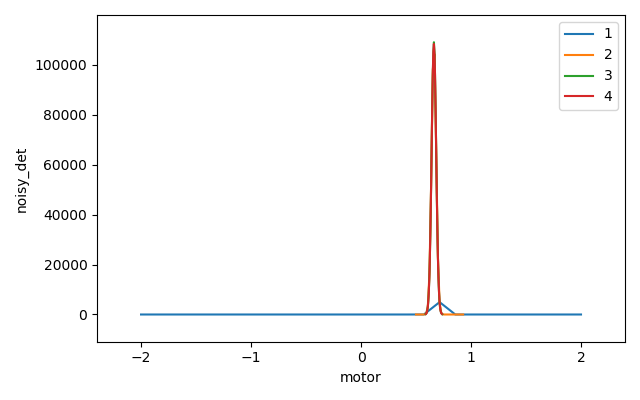

+-----------+------------+------------+------------+
|   seq_num |       time |      motor |  noisy_det |
+-----------+------------+------------+------------+
|         1 | 17:04:32.6 |    -2.0000 |          0 |
|         2 | 17:04:32.6 |    -1.8571 |          0 |
|         3 | 17:04:32.6 |    -1.7143 |          0 |
|         4 | 17:04:32.7 |    -1.5714 |          0 |
|         5 | 17:04:32.7 |    -1.4286 |          0 |
|         6 | 17:04:32.7 |    -1.2857 |          0 |
|         7 | 17:04:32.7 |    -1.1429 |          0 |
|         8 | 17:04:32.7 |    -1.0000 |          0 |
|         9 | 17:04:32.7 |    -0.8571 |          0 |
|        10 | 17:04:32.7 |    -0.7143 |          0 |
|        11 | 17:04:32.7 |    -0.5714 |          0 |
|        12 | 17:04:32.7 |    -0.4286 |          0 |
|        13 | 17:04:32.7 |    -0.2857 |          0 |
|        14 | 17:04:32.7 |    -0.1429 |          0 |
|        15 | 17:04:32.7 |     0.0000 |          0 |
|        16 | 17:04:32.7 |     0.1429 |       

In [5]:
motor.set(cen)
RE(bp.rel_scan([noisy_det], noisy_det._motor, -k*sigma, k*sigma, n))

cen = peaks["cen"]["noisy_det"]
sigma = peaks["fwhm"]["noisy_det"]
results.append((RE.md["scan_id"], cen, sigma))
## Refineprint(cen, sigma)

## Refine the peak position

Refine the scan to the range of (-sigma .. +sigma) near the center of the previous scan.  Repeat as often as necessary to get the peak center and width.

In [8]:
motor.set(cen)
RE(bp.rel_scan([noisy_det], noisy_det._motor, -k*sigma, k*sigma, n))

cen = peaks["cen"]["noisy_det"]
sigma = peaks["fwhm"]["noisy_det"]
results.append((RE.md["scan_id"], cen, sigma))
print(cen, sigma)



Transient Scan ID: 4     Time: 2020-05-05 17:04:56
Persistent Unique Scan ID: '98dfaa73-947b-4c84-9e7a-876c9969fcfa'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |  noisy_det |
+-----------+------------+------------+------------+
|         1 | 17:04:56.4 |     0.5893 |        214 |
|         2 | 17:04:56.4 |     0.5945 |        496 |
|         3 | 17:04:56.4 |     0.5998 |       1045 |
|         4 | 17:04:56.4 |     0.6050 |       2366 |
|         5 | 17:04:56.4 |     0.6102 |       4572 |
|         6 | 17:04:56.4 |     0.6154 |       8260 |
|         7 | 17:04:56.4 |     0.6207 |      14260 |
|         8 | 17:04:56.4 |     0.6259 |      22744 |
|         9 | 17:04:56.4 |     0.6311 |      34840 |
|        10 | 17:04:56.5 |     0.6364 |      48869 |
|        11 | 17:04:56.5 |     0.6416 |      65012 |
|        12 | 17:04:56.5 |     0.6468 |      81594 |
|        13 | 17:04:56.5 |     0.6521 |      95299 |
|        14

## Report the results

Print a nice table with the results from each of our scans.

In [9]:
tbl = pyRestTable.Table()
tbl.addLabel("scan ID")
tbl.addLabel("center")
tbl.addLabel("sigma")
for sid, cen, sigma in results:
    tbl.addRow((sid, cen, sigma))
print(tbl)

======= ================== ====================
scan ID center             sigma               
======= ================== ====================
1       0.7142352092352089 0.14295815295815295 
2       0.6628253768078791 0.05101964894073674 
3       0.662523705337113  0.04882234595400292 
4       0.6625135402240261 0.048807524395105495
======= ================== ====================

